## (a) Exploratory Data Analysis

In [25]:
!pip install tabulate

import numpy as np
from tabulate import tabulate

import nrrd
import os
import shutil
import tempfile
import torch

import matplotlib.pyplot as plt    
from tqdm import tqdm

import nrrd
import json



from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
)
print("A")
from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)
print_config()

A
MONAI version: 1.4.dev2416
Numpy version: 1.26.3
Pytorch version: 2.2.2+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: d487995c8f685729ee5e1259f364034dab4811da
MONAI __file__: C:\Users\<username>\miniconda3\envs\tdt4265_project\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.3.0
Nibabel version: 5.2.1
scikit-image version: 0.22.0
scipy version: 1.13.0
Pillow version: 10.3.0
Tensorboard version: 2.16.2
gdown version: 4.7.3
TorchVision version: 0.17.2+cu118
tqdm version: 4.66.1
lmdb version: 1.4.1
psutil version: 5.9.8
pandas version: 2.2.2
einops version: 0.7.0
transformers version: 4.40.0
mlflow version: 2.11.3
pynrrd version: 1.0.0
clearml version: 1.15.1

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



# Data Analysis
## analysing the dataset given of nnrd format, mainly to check the shape of the data so that we can know how to do proper data augmentation

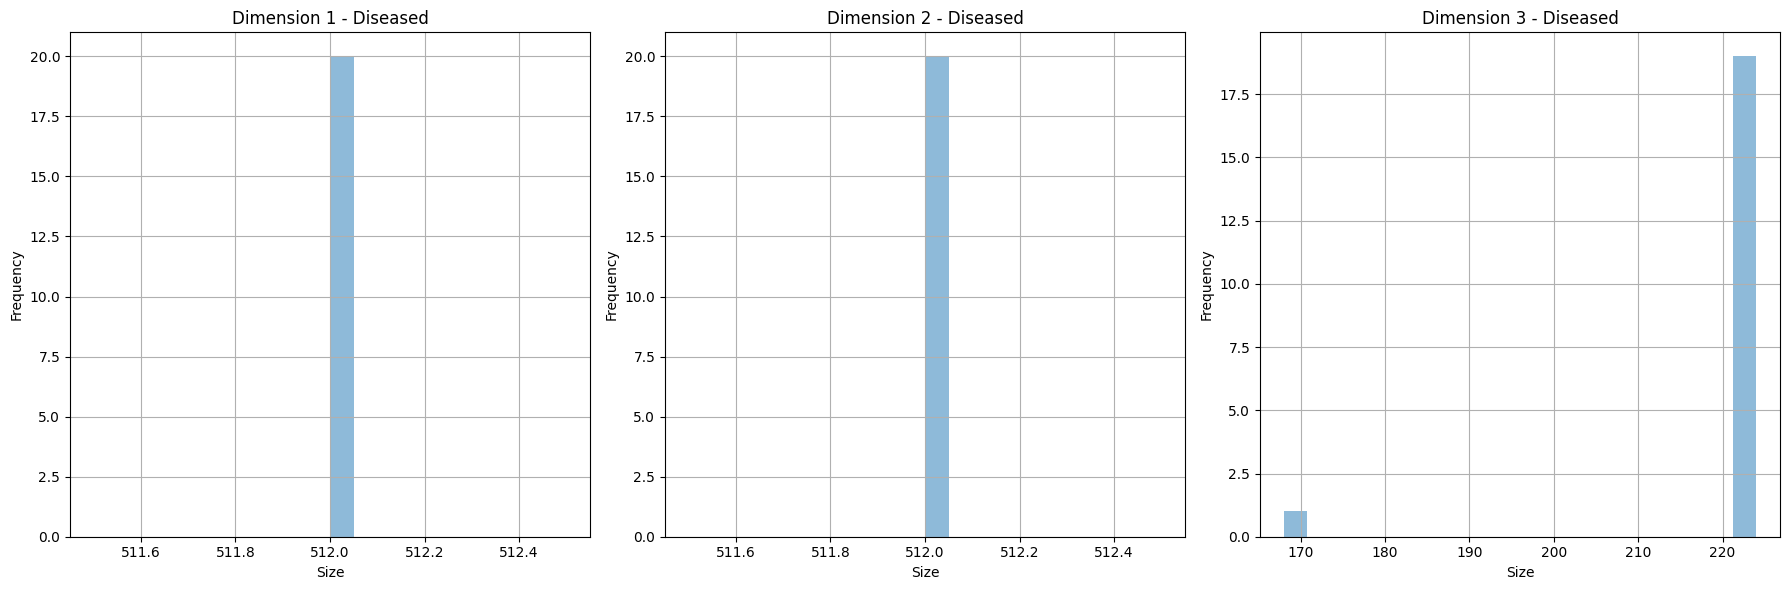

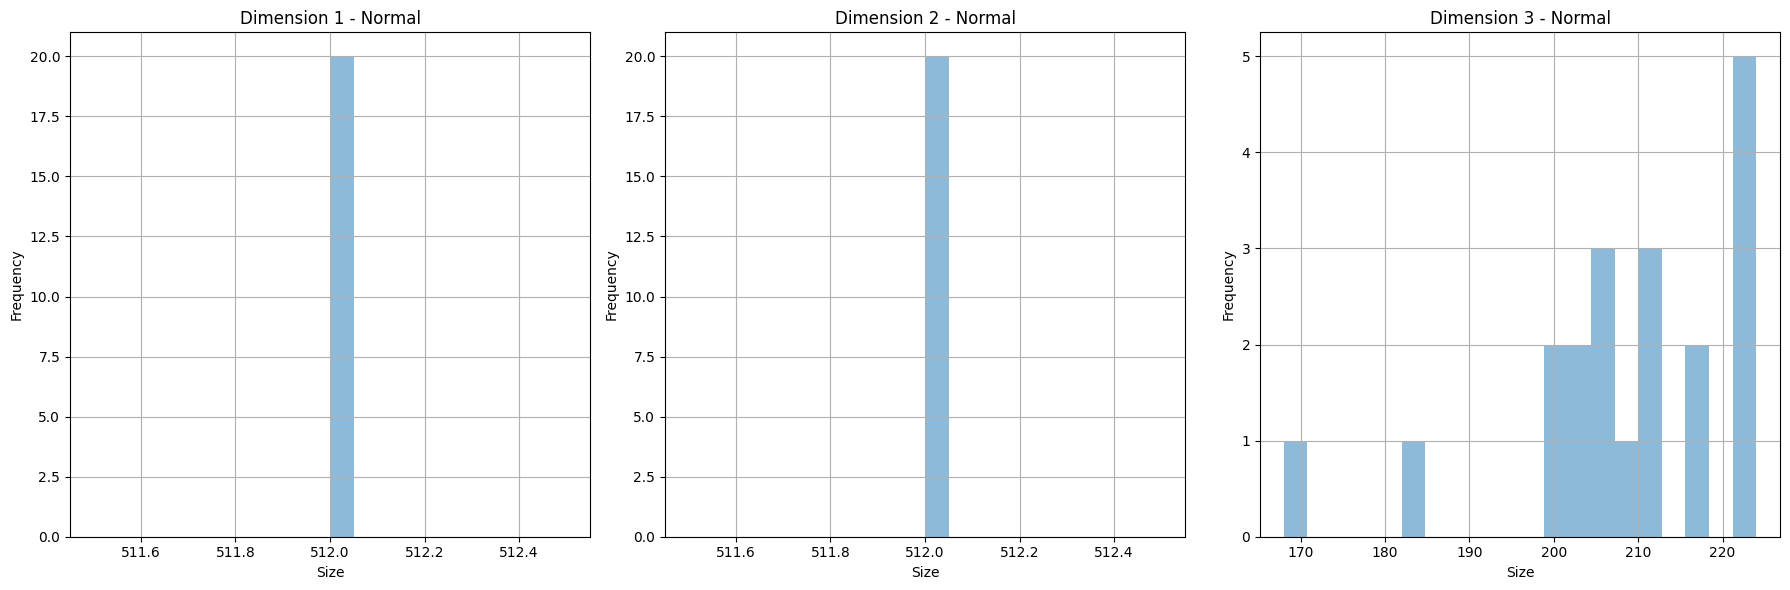

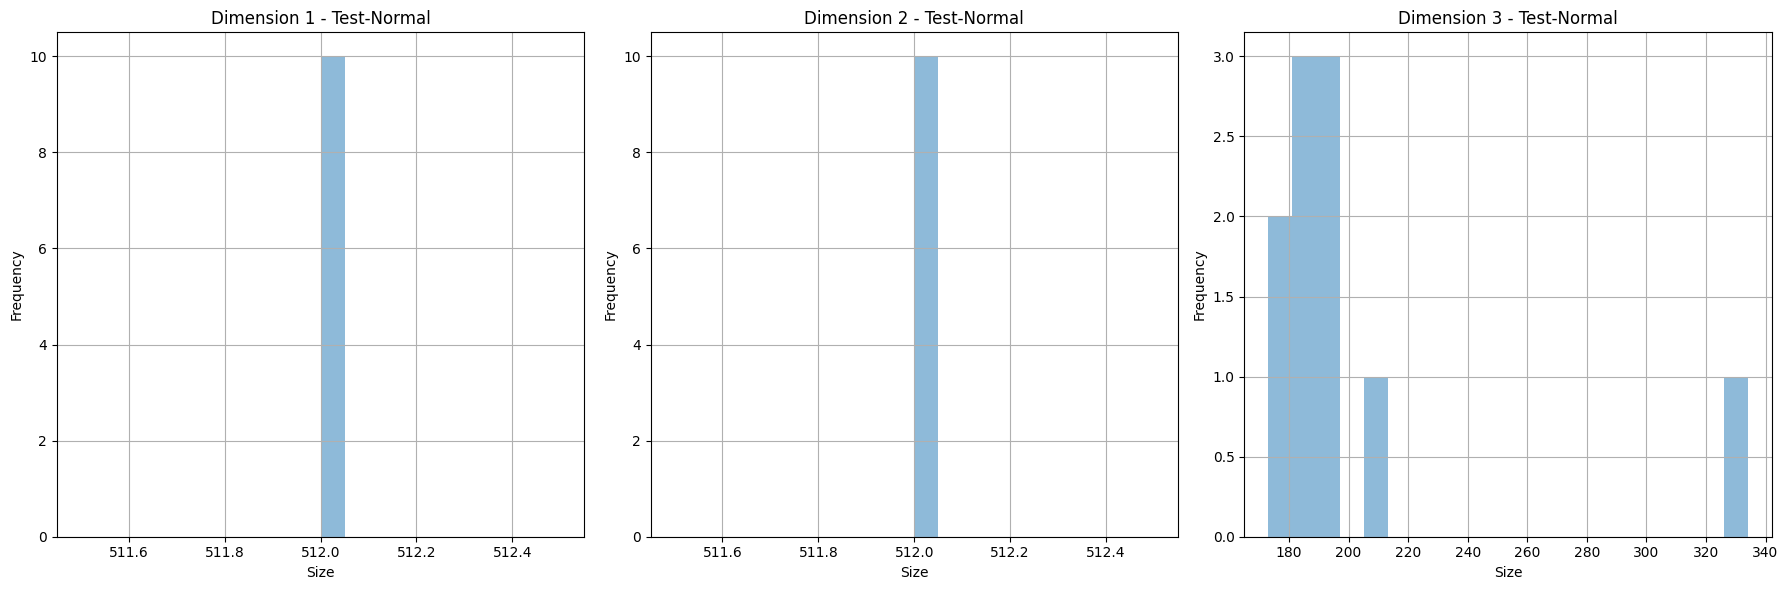

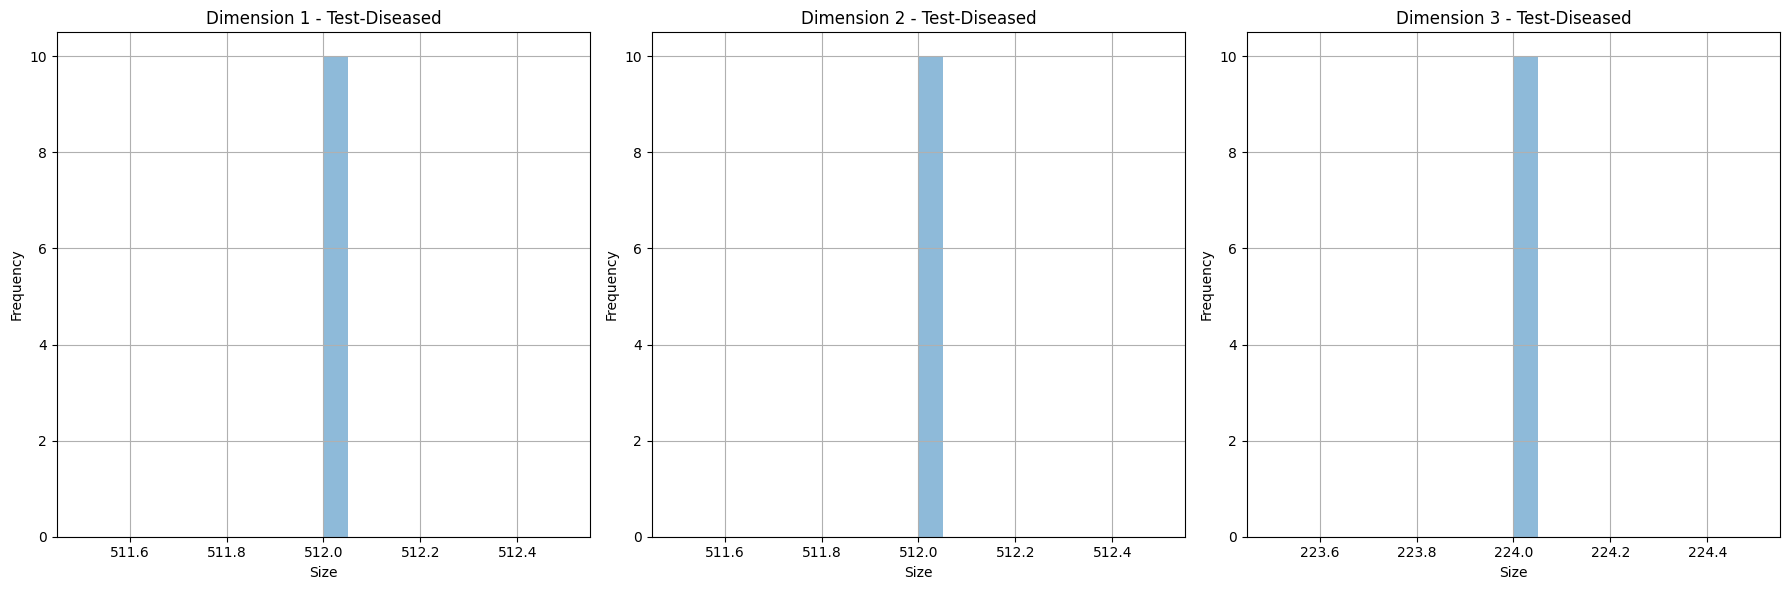

In [29]:

data_dir = r"C:\Users\jefft\TDT4265_StarterCode_2024\Project\Dataset\\"
split_json = "EDA_dataset.json"

datasets = data_dir + split_json
# Load the JSON data
with open(datasets) as f:
    data = json.load(f)

# Define a function to read image data
def read_image(image_path):
    img_obj = nrrd.read(data_dir+image_path)
    img_data, _ = img_obj
    return img_data

# Initialize dictionaries to store shapes for each dataset type
shapes = {"Diseased": {"dim1": [], "dim2": [], "dim3": []},
          "Normal": {"dim1": [], "dim2": [], "dim3": []},
         "Test-Normal": {"dim1": [], "dim2": [], "dim3": []},
        "Test-Diseased": {"dim1": [], "dim2": [], "dim3": []}}

# Iterate over the different type of data
for dataset_type in ["Diseased", "Normal","Test-Normal","Test-Diseased"]:
    for item in data[dataset_type]:
        image_path = item["image"]
        image_data = read_image(image_path)
        shape = image_data.shape
        shapes[dataset_type]["dim1"].append(shape[0])
        shapes[dataset_type]["dim2"].append(shape[1])
        shapes[dataset_type]["dim3"].append(shape[2])

# Plot histograms for each dataset type for all three dimensions
for dataset_type in ["Diseased", "Normal","Test-Normal","Test-Diseased"]:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].hist(shapes[dataset_type]["dim1"], bins=20, alpha=0.5)
    axes[0].set_title(f'Dimension 1 - {dataset_type}')
    axes[0].set_xlabel('Size')
    axes[0].set_ylabel('Frequency')
    axes[0].grid(True)

    axes[1].hist(shapes[dataset_type]["dim2"], bins=20, alpha=0.5)
    axes[1].set_title(f'Dimension 2 - {dataset_type}')
    axes[1].set_xlabel('Size')
    axes[1].set_ylabel('Frequency')
    axes[1].grid(True)

    axes[2].hist(shapes[dataset_type]["dim3"], bins=20, alpha=0.5)
    axes[2].set_title(f'Dimension 3 - {dataset_type}')
    axes[2].set_xlabel('Size')
    axes[2].set_ylabel('Frequency')
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

In [30]:
# Calculate mean values for each dimension for each dataset type
mean_dims = {}
for dataset_type in shapes.keys():
    mean_dims[dataset_type] = {
        "dim1_mean": np.mean(shapes[dataset_type]["dim1"]),
        "dim2_mean": np.mean(shapes[dataset_type]["dim2"]),
        "dim3_mean": np.mean(shapes[dataset_type]["dim3"])
    }

# Prepare data for tabulate
table_data = []
for dataset_type, means in mean_dims.items():
    table_data.append([dataset_type, means['dim1_mean'], means['dim2_mean'], means['dim3_mean']])

# Print the table
headers = ["Dataset Type", "Dimension 1 Mean", "Dimension 2 Mean", "Dimension 3 Mean"]
print(tabulate(table_data, headers=headers, tablefmt="pipe"))

| Dataset Type   |   Dimension 1 Mean |   Dimension 2 Mean |   Dimension 3 Mean |
|:---------------|-------------------:|-------------------:|-------------------:|
| Diseased       |                512 |                512 |              221.2 |
| Normal         |                512 |                512 |              208.7 |
| Test-Normal    |                512 |                512 |              202.7 |
| Test-Diseased  |                512 |                512 |              224   |


We can see that from the histogram and the mean table , the X , Y values of the 3d image remains constant at 512. However, the Z dimension which are the number of slices each 3d image has varies. Except for the fact that 19 out of 20 3d images in Diseased folder has the same Z dimension of 224, having only one outlier.

# Data Preprocessing
The data form above are now preprocessing manually into 3 different folder, called Training, Validation and Testing respectively. Using a 80%-20% split of the original dataset of 40 training data of both normal and diseased patient. We have Training dataset that consist of 80% of the original 40 training data of both normal and diseased patient mixed. Where Validation dataset consist 20% of the original 40 training data of both normal and diseased patient mixed. The testing dataset is as per original data receive , 20 CTCA scans of both normal and diseased patient.

The data preprocessing is done with a json file

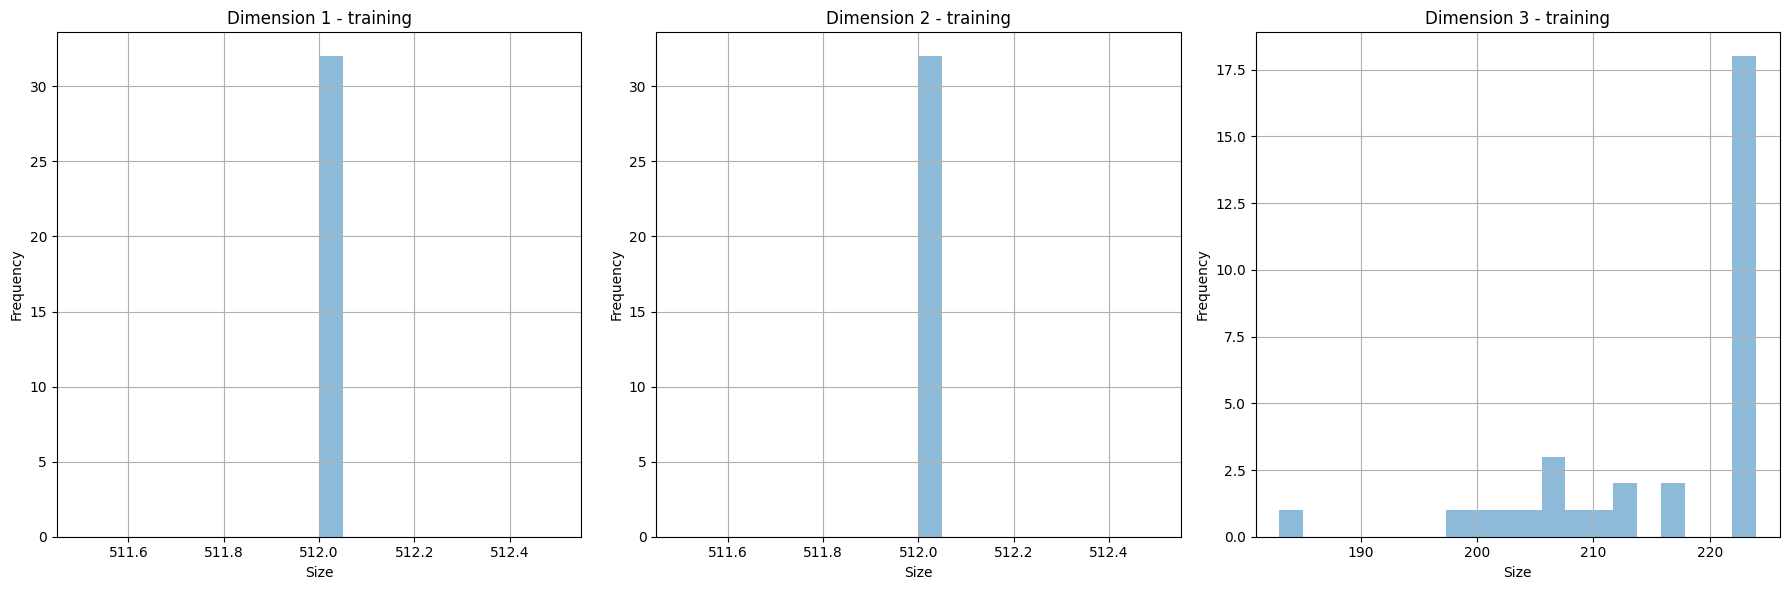

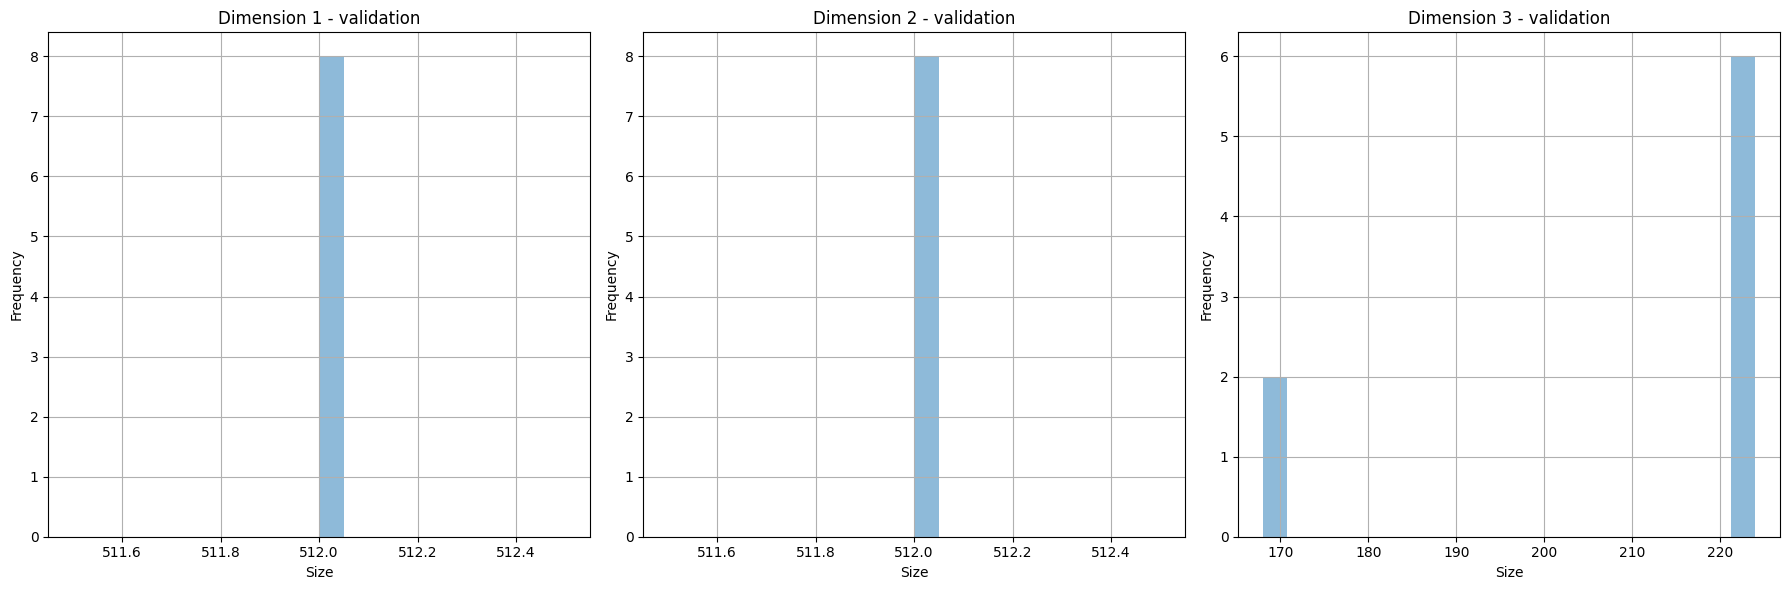

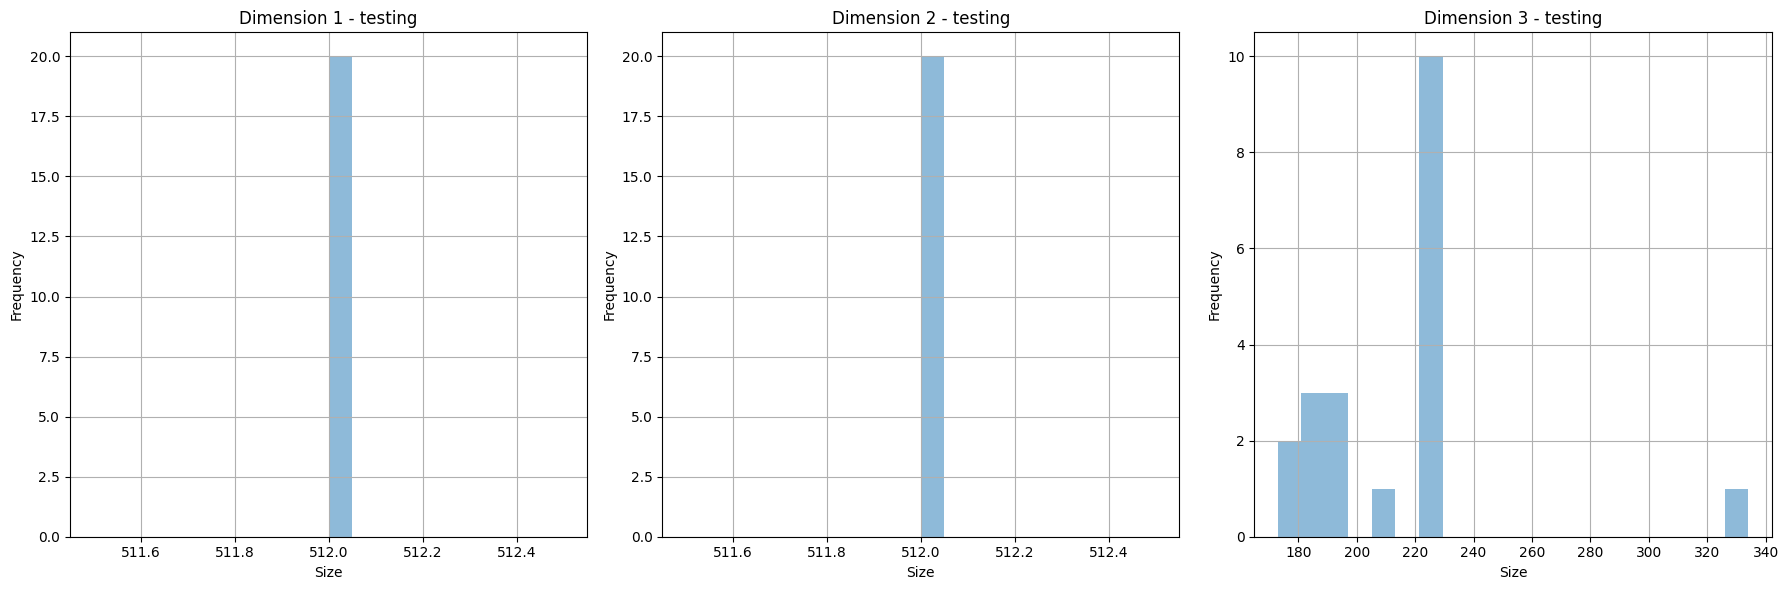

In [32]:
import json
import nrrd
data_dir = r"C:\Users\jefft\TDT4265_StarterCode_2024\Project\Dataset\\"
split_json = "dataset_0.json"

datasets = data_dir + split_json
# Load the JSON data
with open(datasets) as f:
    data = json.load(f)

# Define a function to read image data
def read_image(image_path):
    img_obj = nrrd.read(data_dir+image_path)
    img_data, _ = img_obj
    return img_data

# Initialize dictionaries to store shapes for each dataset type
shapes = {"training": {"dim1": [], "dim2": [], "dim3": []},
          "validation": {"dim1": [], "dim2": [], "dim3": []},
          "testing": {"dim1": [], "dim2": [], "dim3": []}}

# Iterate over the training, validation, and testing sets
for dataset_type in ["training", "validation", "testing"]:
    for item in data[dataset_type]:
        image_path = item["image"]
        image_data = read_image(image_path)
        shape = image_data.shape
        shapes[dataset_type]["dim1"].append(shape[0])
        shapes[dataset_type]["dim2"].append(shape[1])
        shapes[dataset_type]["dim3"].append(shape[2])

# Plot histograms for each dataset type for all three dimensions
for dataset_type in ["training", "validation", "testing"]:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].hist(shapes[dataset_type]["dim1"], bins=20, alpha=0.5)
    axes[0].set_title(f'Dimension 1 - {dataset_type}')
    axes[0].set_xlabel('Size')
    axes[0].set_ylabel('Frequency')
    axes[0].grid(True)

    axes[1].hist(shapes[dataset_type]["dim2"], bins=20, alpha=0.5)
    axes[1].set_title(f'Dimension 2 - {dataset_type}')
    axes[1].set_xlabel('Size')
    axes[1].set_ylabel('Frequency')
    axes[1].grid(True)

    axes[2].hist(shapes[dataset_type]["dim3"], bins=20, alpha=0.5)
    axes[2].set_title(f'Dimension 3 - {dataset_type}')
    axes[2].set_xlabel('Size')
    axes[2].set_ylabel('Frequency')
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

In [34]:
# Calculate mean values for each dimension for each dataset type
mean_dims = {}
for dataset_type in shapes.keys():
    mean_dims[dataset_type] = {
        "dim1_mean": np.mean(shapes[dataset_type]["dim1"]),
        "dim2_mean": np.mean(shapes[dataset_type]["dim2"]),
        "dim3_mean": np.mean(shapes[dataset_type]["dim3"])
    }

# Prepare data for tabulate
table_data = []
for dataset_type, means in mean_dims.items():
    table_data.append([dataset_type, means['dim1_mean'], means['dim2_mean'], means['dim3_mean']])

# Print the table
headers = ["Dataset Type", "Dimension 1 Mean", "Dimension 2 Mean", "Dimension 3 Mean"]
print(tabulate(table_data, headers=headers, tablefmt="pipe"))

| Dataset Type   |   Dimension 1 Mean |   Dimension 2 Mean |   Dimension 3 Mean |
|:---------------|-------------------:|-------------------:|-------------------:|
| training       |                512 |                512 |            216.188 |
| validation     |                512 |                512 |            210     |
| testing        |                512 |                512 |            213.35  |


## (b) Data Augmentations Testing
